In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches

from astropy import coordinates
from astropy import units as u
from astropy.io import fits

from shapely import geometry
from shapely.ops import unary_union
from shapely.geometry import Point
from descartes.patch import PolygonPatch

from skipper import observe

In [4]:
def read_tile_file(filename):
    hdul = fits.open(filename)
    data = hdul[1].data
    tileID = data['TILEID']
    pass_num = data['PASS']
    ra = data['RA']
    dec = data['DEC']
    
    return tileID, pass_num, ra, dec

### import tiliing file

In [5]:
tileID, pass_num, ra, dec = read_tile_file('../data/decam-tiles-decals-merian.fits')
tileID_shift, pass_num_shift, ra_shift, dec_shift = read_tile_file('../data/shifted-tiles-decals-merian.fits.gz')

circle_radius = (3.18/np.pi)**0.5

### import the GAMA09 field edge

In [6]:
g09edges = np.loadtxt('../data/g09edge.dat')
poly_g09 = geometry.Polygon(g09edges)  
print('The GAMA09 field area is: ' + str(poly_g09.area))
print('Fraction of the entire Merian Survey is: '+str(100*poly_g09.area/800))

The GAMA09 field area is: 140.6957220611181
Fraction of the entire Merian Survey is: 17.58696525763976


(-3.0, 6.0)

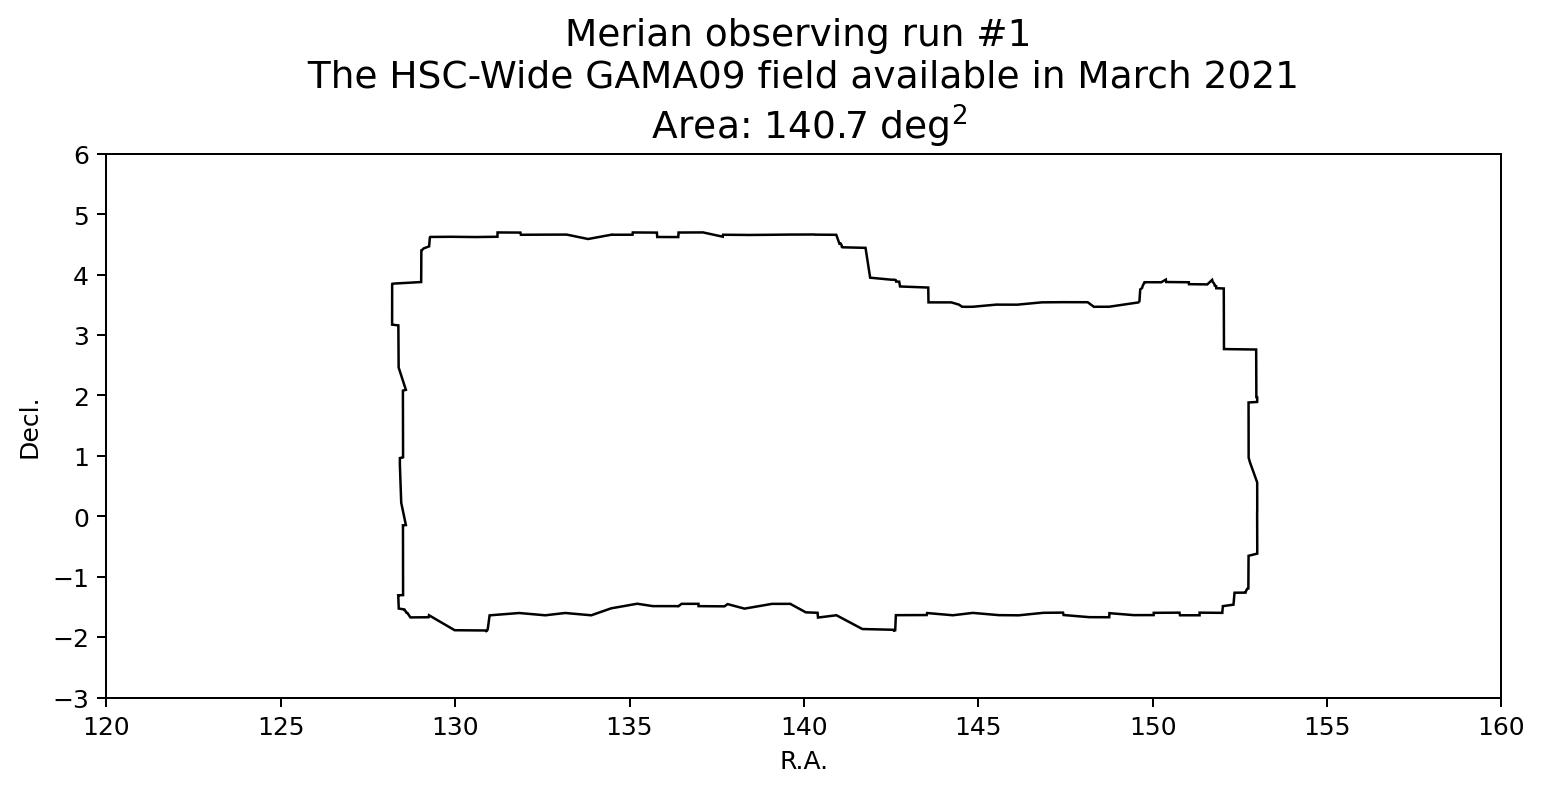

In [9]:
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
fig = plt.figure(1, figsize=(10, 4), dpi=180)
ax = fig.add_subplot(111)
ax.add_patch(patch1)
ax.set_title('Merian observing run #1 \n The HSC-Wide GAMA09 field available in March 2021 \n Area: '+ str(round(poly_g09.area,1)) + ' deg$^2$'
             ,fontsize=15)
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
ax.set_xlim(120,160)
ax.set_ylim(-3,6)

### check the overlap between circles and the HSC footprint


In [10]:
ra1 = [ra[i] for i in range(len(ra)) if pass_num[i] == 1]
dec1 = [dec[i] for i in range(len(dec)) if pass_num[i] == 1]
ra2 = [ra[i] for i in range(len(ra)) if pass_num[i] == 2]
dec2 = [dec[i] for i in range(len(dec)) if pass_num[i] == 2]
ra3 = [ra[i] for i in range(len(ra)) if pass_num[i] == 3]
dec3 = [dec[i] for i in range(len(dec)) if pass_num[i] == 3]
ra4 = [ra[i] for i in range(len(ra)) if pass_num[i] == 4]
dec4 = [dec[i] for i in range(len(dec)) if pass_num[i] == 4]

ra1_shift = [ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 1]
dec1_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 1]
ra2_shift = [ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 2]
dec2_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 2]
ra3_shift = [ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 3]
dec3_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 3]
ra4_shift = [ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 4]
dec4_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 4]

## make circles for the original tiling pattern

In [11]:
# pass 1
circles_pass1 = [Point(ra1[i],dec1[i]).buffer(circle_radius) for i in range(len(ra1))]
# all_circles_pass1 = unary_union(circles_pass1)
# pass 2
circles_pass2 = [Point(ra2[i],dec2[i]).buffer(circle_radius) for i in range(len(ra2))]
# all_circles_pass2 = unary_union(circles_pass2)
# pass 3
circles_pass3 = [Point(ra3[i],dec3[i]).buffer(circle_radius) for i in range(len(ra3))]
# all_circles_pass3 = unary_union(circles_pass3)
# pass 4
circles_pass4 = [Point(ra4[i],dec4[i]).buffer(circle_radius) for i in range(len(ra4))]
# all_circles_pass4 = unary_union(circles_pass4)

## make circles for the shifted tiling pattern (shifted by 1 deg in dec)

In [12]:
# pass 1
circles_pass1_shift = [Point(ra1_shift[i],dec1_shift[i]).buffer(circle_radius) for i in range(len(ra1_shift))]
# all_circles_pass1 = unary_union(circles_pass1)
# pass 2
circles_pass2_shift = [Point(ra2_shift[i],dec2_shift[i]).buffer(circle_radius) for i in range(len(ra2_shift))]
# all_circles_pass2 = unary_union(circles_pass2)
# pass 3
circles_pass3_shift = [Point(ra3_shift[i],dec3_shift[i]).buffer(circle_radius) for i in range(len(ra3_shift))]
# all_circles_pass3 = unary_union(circles_pass3)
# pass 4
circles_pass4_shift = [Point(ra4_shift[i],dec4_shift[i]).buffer(circle_radius) for i in range(len(ra4_shift))]
# all_circles_pass4 = unary_union(circles_pass4)

### now we calculate the overlap of pass1 with the HSC GAMA09 area


In [14]:
# pass 1
pass1_circle_any_overlap = []
pass1_circle_overlap_index = []
fov_area = 3.18
fraction = 0.2
index_use = []
for i in range(len(circles_pass1_shift)):
    inter = poly_g09.intersection(circles_pass1_shift[i])
    if inter.area > 0:
        pass1_circle_any_overlap.append(circles_pass1_shift[i])
        if inter.area/3.18 > fraction:
            pass1_circle_overlap_index.append(1)
            index_use.append(i)
        else:
            pass1_circle_overlap_index.append(0)
            

# pass 2
pass2_circle_any_overlap = []
pass2_circle_overlap_index = []
fov_area = 3.18
for i in range(len(circles_pass2_shift)):
    inter = poly_g09.intersection(circles_pass2_shift[i])
    if inter.area > 0:
        pass2_circle_any_overlap.append(circles_pass2_shift[i])
        if inter.area/3.18 > fraction:
            pass2_circle_overlap_index.append(1)
        else:
            pass2_circle_overlap_index.append(0)
            
# pass 3
pass3_circle_any_overlap = []
pass3_circle_overlap_index = []
fov_area = 3.18
for i in range(len(circles_pass3_shift)):
    inter = poly_g09.intersection(circles_pass3_shift[i])
    if inter.area > 0:
        pass3_circle_any_overlap.append(circles_pass3_shift[i])
        if inter.area/3.18 > fraction:
            pass3_circle_overlap_index.append(1)
        else:
            pass3_circle_overlap_index.append(0)     

# pass 4
pass4_circle_any_overlap = []
pass4_circle_overlap_index = []
fov_area = 3.18
for i in range(len(circles_pass4_shift)):
    inter = poly_g09.intersection(circles_pass4_shift[i])
    if inter.area > 0:
        pass4_circle_any_overlap.append(circles_pass4_shift[i])
        if inter.area/3.18 > fraction:
            pass4_circle_overlap_index.append(1)
        else:
            pass4_circle_overlap_index.append(0)            

Text(0.5, 1.0, 'minimal required overlap with the G09 field: 20%')

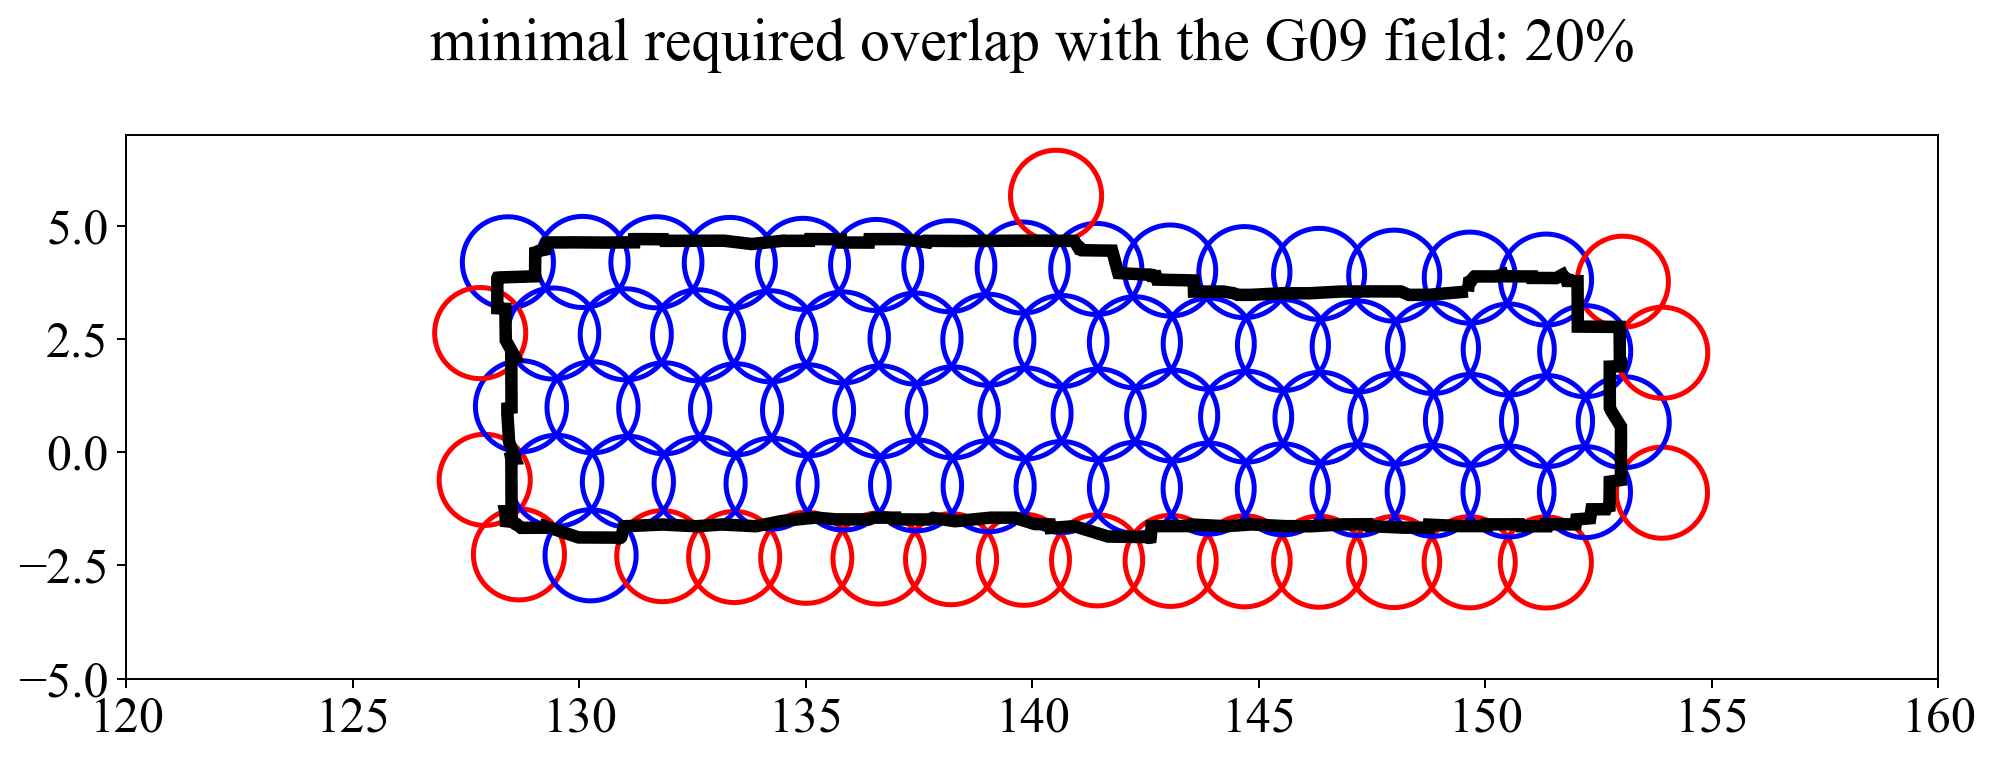

In [16]:
fig = plt.figure(1, figsize=(15,4), dpi=180)
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] = 20
plt.rcParams['axes.titlepad'] = 30

ax = fig.add_subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=5)
for i in range(len(pass1_circle_any_overlap)):
    if pass1_circle_overlap_index[i] == 1:
        patch2 = PolygonPatch(pass1_circle_any_overlap[i],lw=2,facecolor='none',edgecolor='b')
    else:
        patch2 = PolygonPatch(pass1_circle_any_overlap[i],lw=2,facecolor='none',edgecolor='r')
    ax.add_patch(patch2)
ax.add_patch(patch1)
ax.set_xlim(120,160)
ax.set_ylim(-5,7)
plt.title('minimal required overlap with the G09 field: '+str(round(100*fraction))+'%')


In [18]:
print('# of pointings in one pass: ' +str(len(index_use)))

# of pointings in one pass: 62


## plot all four passes that overlap with the GAMA09 field

Text(0.5, 1.0, 'fraction outside G09 field: 0.2')

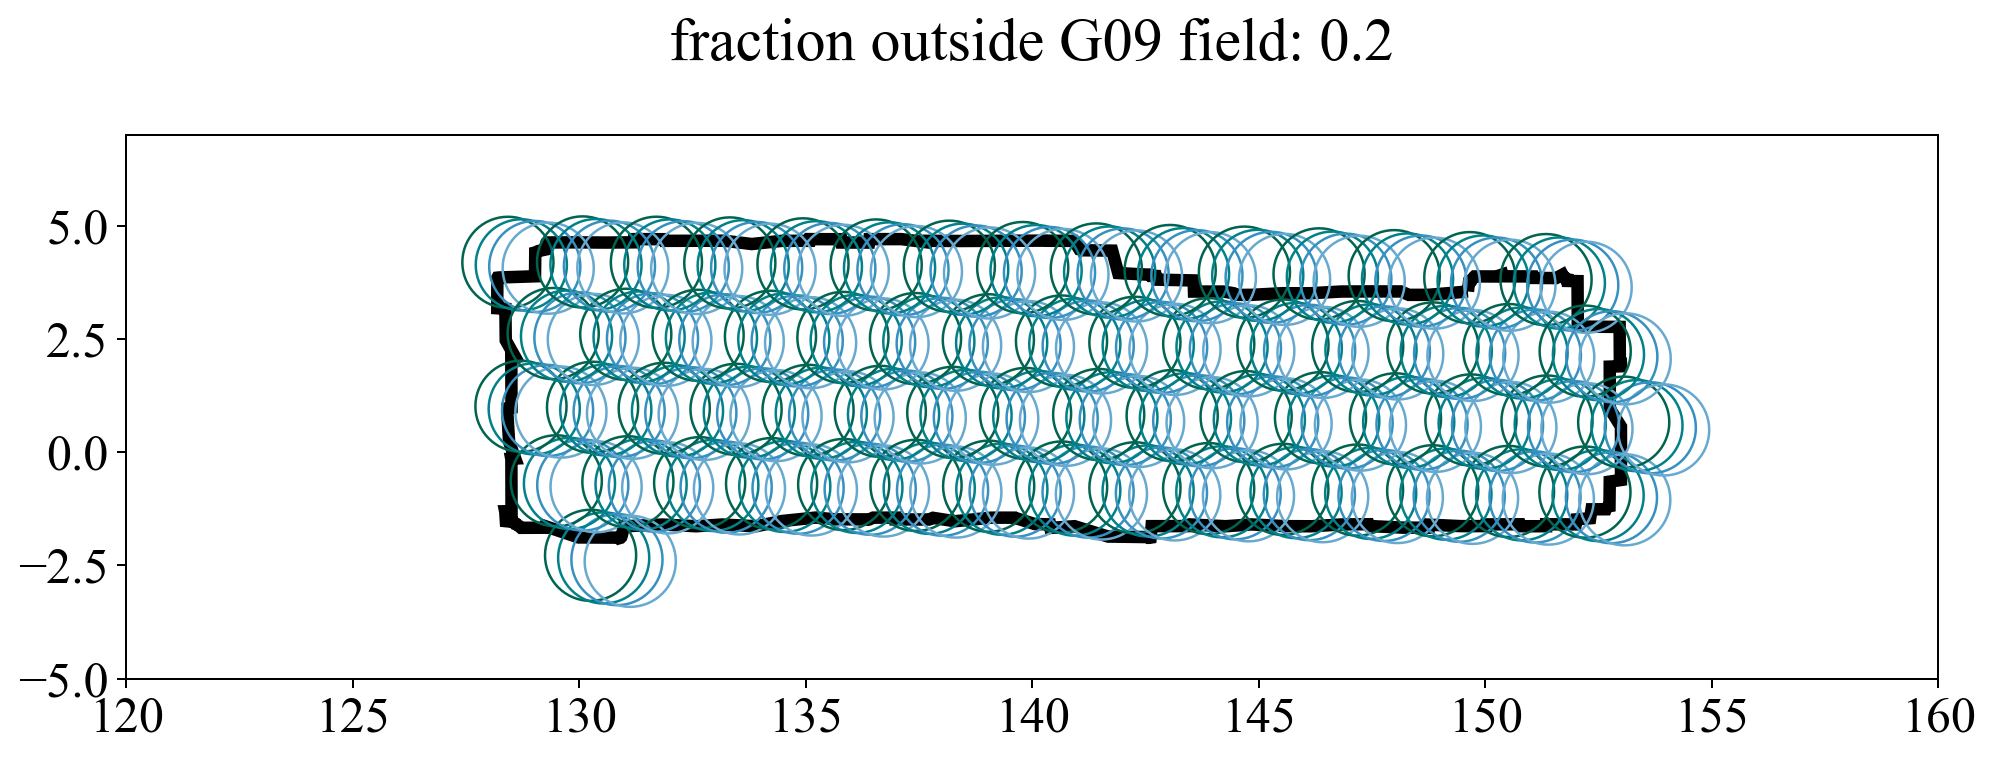

In [20]:
fig = plt.figure(1, figsize=(15,4), dpi=180)
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] = 20
plt.rcParams['axes.titlepad'] = 30

ax = fig.add_subplot(111, aspect='equal')
patch = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=5)
ax.add_patch(patch)

point_counter = 0

for i in range(len(index_use)):
    patch1 = PolygonPatch(circles_pass1_shift[index_use[i]],lw=1,facecolor='none',edgecolor='#016450')
    patch2 = PolygonPatch(circles_pass2_shift[index_use[i]],lw=1,facecolor='none',edgecolor='#02818a')
    patch3 = PolygonPatch(circles_pass3_shift[index_use[i]],lw=1,facecolor='none',edgecolor='#3690c0')
    patch4 = PolygonPatch(circles_pass4_shift[index_use[i]],lw=1,facecolor='none',edgecolor='#67a9cf')

    point_counter +=4
    
    ax.add_patch(patch1)
    ax.add_patch(patch2)
    ax.add_patch(patch3)
    ax.add_patch(patch4)
        
ax.set_xlim(120,160)
ax.set_ylim(-5,7)
plt.title('fraction outside G09 field: '+str(fraction))


In [21]:
frac_from_survey = round((100*poly_g09.area/800.),1)
total_nights = 30
print('Total area of the GAMA09 field: ' + str(round(poly_g09.area,1)))
print('Which is '+ str(frac_from_survey)+ '% of the total Merian Survey area')
print('So given that we have 30 nights for the wide survey in one filter, we want to spend on this field '+str(total_nights*frac_from_survey/100)+' nights')
print('With this plan, the mumber of pointings for the GAMA09 field: ' + str(point_counter))

print('Each pointing is 10 minutes, so we will spend a total of: ' + str(round(point_counter*10/60,1))+' hours on this field')
print('Assuming 8 hours a night, that means: ' + str(round(point_counter*10/60/8,2)) + ' nights')


Total area of the GAMA09 field: 140.7
Which is 17.6% of the total Merian Survey area
So given that we have 30 nights for the wide survey in one filter, we want to spend on this field 5.28 nights
With this plan, the mumber of pointings for the GAMA09 field: 248
Each pointing is 10 minutes, so we will spend a total of: 41.3 hours on this field
Assuming 8 hours a night, that means: 5.17 nights


# of pointings: 248


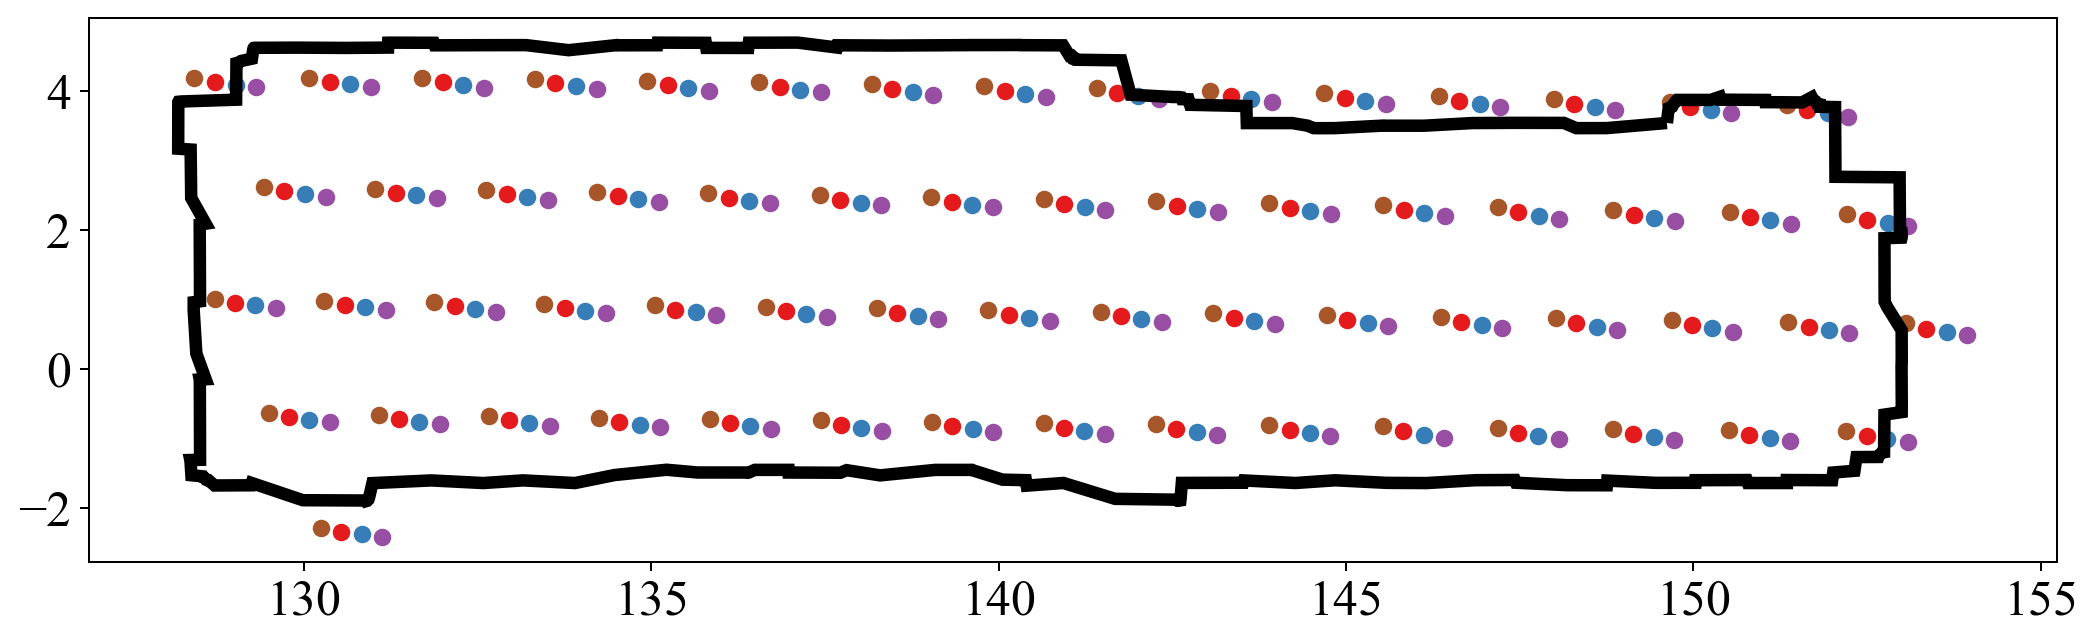

In [22]:
fig = plt.figure(1, figsize=(15,4), dpi=180)
ax = fig.add_subplot(111, aspect='equal')
count_again = 0
ra_g09_final = []
dec_g09_final = []
for i in range(len(index_use)):
    count_again += 4
    j = index_use[i]
    ax.scatter(ra1_shift[j],dec1_shift[j],color='#a65628')
    ax.scatter(ra2_shift[j],dec2_shift[j],color='#e41a1c')
    ax.scatter(ra3_shift[j],dec3_shift[j],color='#377eb8')
    ax.scatter(ra4_shift[j],dec4_shift[j],color='#984ea3')
    
    # append coordiantes to the final catalog
    ra_g09_final.append(ra1_shift[j])
    ra_g09_final.append(ra2_shift[j])
    ra_g09_final.append(ra3_shift[j])
    ra_g09_final.append(ra4_shift[j])
    dec_g09_final.append(dec1_shift[j])
    dec_g09_final.append(dec2_shift[j])
    dec_g09_final.append(dec3_shift[j])
    dec_g09_final.append(dec4_shift[j])
    
patch = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=5)
ax.add_patch(patch)

print('# of pointings: ' + str(count_again))

In [24]:
print('total # of pointings for the G09 field: '+str(point_counter)) 

total # of pointings for the G09 field: 248


## initialize ObservingCatalog; build JSON file

In [26]:
ocat = observe.ObsCatalog (comment='G09', proposer='LeathaudGreene')
df = ocat.build_catalog (ra_g09_final, dec_g09_final, 'G09', 'N708', 'science', 10.*60)
ocat.to_json(df)